In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]
%matplotlib inline

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 256  # object size in x,y
nz = 256  # object size in z    
ntheta = 256  # number of angles (rotations)

pnz = nz # tomography chunk size for GPU processing (dont change if data is small and fits gpu memory)
ptheta = ntheta # holography chunk size for GPU processing

center = n/2 # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32') # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n # [m] object voxel size 
energy = 33.35  # [keV] x-ray energy    
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy # [m]
focusToDetectorDistance = 1.28 # [m]
sx0 = 3.7e-4 # [m] motor offset from the focal spot
ncodes = 1
z1 = np.tile(np.array([4.584e-3]),ncodes)-sx0 # distances between planes and the focal spot
z2 = focusToDetectorDistance-z1 # distances between planes and the detector
magnifications = focusToDetectorDistance/z1 # actual magnifications
# magnifications = magnifications*0+1
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/focusToDetectorDistance # propagation distances after switching from the point source wave to plane wave,
#distances*=100
distances = distances*norm_magnifications**2 # scaled propagation distancesc due to magnified probes

## Read real and imaginary parts of the refractive index u = delta+i beta

In [3]:
data = np.zeros([ncodes,ntheta,nz,n],dtype='float32')
prb = np.zeros([ncodes,ntheta,nz,n],dtype='complex64')
for k in range(ncodes):
    data[k] = dxchange.read_tiff(f'/data/modeling/data_{n}_{k}.tiff')[:]
for k in range(ncodes):
    prb[k] = dxchange.read_tiff(f'/data/modeling/prb_amp_{n}_{k}.tiff')[:]*np.exp(1j*dxchange.read_tiff(f'/data/modeling/prb_angle_{n}_{k}.tiff')[:])


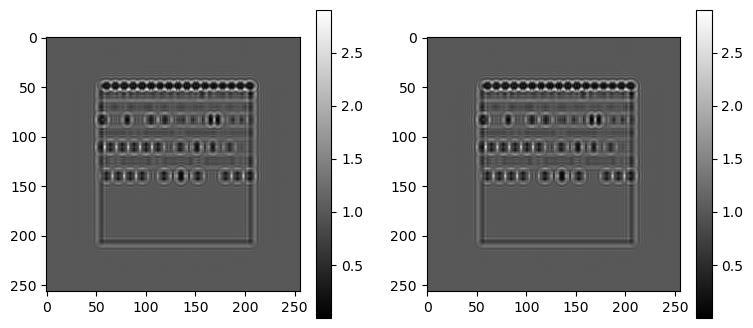

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(data[0,0],cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(data[-1,0],cmap='gray')
fig.colorbar(im)

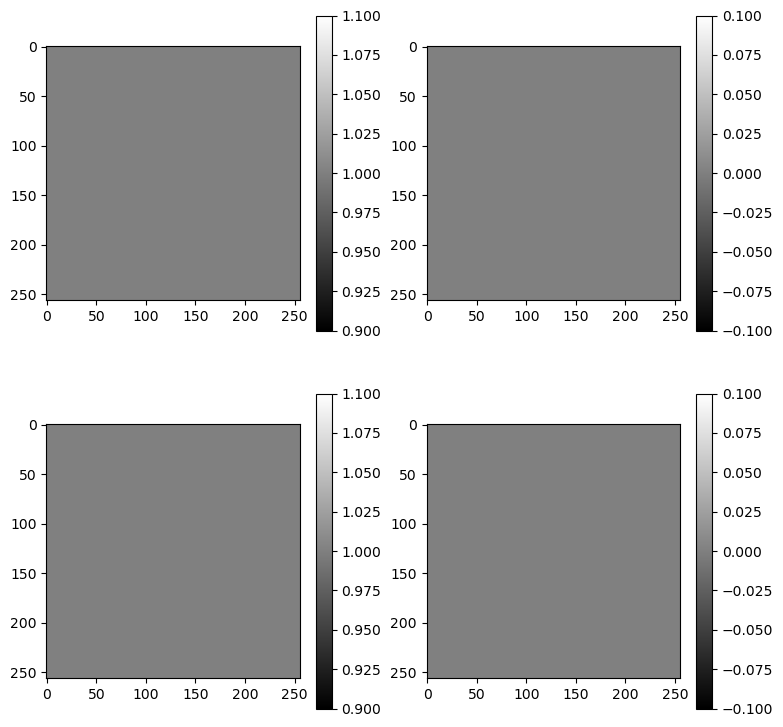

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(np.abs(prb[0,0]),cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(np.angle(prb[0,0]),cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(np.abs(prb[0,-1]),cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(np.angle(prb[0,-1]),cmap='gray')
fig.colorbar(im)

Note that in this formation delta is negative

## Create a solver class for tomography

In [6]:
tslv = holotomo.SolverTomo(theta, ntheta, nz, n, pnz, center)

note pnz parameter is used to define the number of slices for simultaneous processing by 1 gpu. Currently pnz=nz. If the gpu does not have enough memory then pnz should  be decreased

## Create a solver class for holography

In [7]:
pslv = holotomo.SolverHolo(ntheta, nz, n, ptheta, voxelsize, energy, distances, norm_magnifications)

# Solving the problem $\sum_{k,j}\||\mathcal{G}_kq_k \psi_j|-d_{k,j}\|_2\to min$ with the Conjugate Gradient

note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

In [8]:
import cupy as cp

def line_search(minf, gamma, u, fu, d, fd):
    """ Line search for the step sizes gamma"""
    while(minf(u, fu)-minf(u+gamma*d, fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma
    
def cg_holo(data, init, prb,  piter):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(psi,fpsi):
        f = cp.linalg.norm(cp.abs(fpsi)-cp.sqrt(data))**2            
        # f = cp.linalg.norm(cp.abs(fpsi)**2-data)**2            
        return f        
    psi = init.copy()
    
    maxprb = cp.max(cp.abs(prb))
    gamma = 1# init gamma as a large value
    for i in range(piter):
        fpsi = pslv.fwd_holo(psi,prb)
        grad = pslv.adj_holo(
           fpsi-cp.sqrt(data)*cp.exp(1j*cp.angle(fpsi)), prb)/maxprb**2
        #grad = pslv.adj_holo(
             #(cp.abs(fpsi)**2-data)*fpsi,prb)/maxprb**2
        
        # Dai-Yuan direction
        if i == 0:
            d = -grad
        else:
            c = cp.linalg.norm(grad,axis=(1,2))**2/cp.sum(cp.conj(d)*(grad-grad0),axis=(1,2))            
            d = -grad+c[:,np.newaxis,np.newaxis]*d
# 
            # d = -grad+cp.linalg.norm(grad)**2 / \
                # ((cp.sum(cp.conj(d)*(grad-grad0))))*d
        grad0 = grad
        # line search
        fd = pslv.fwd_holo(d, prb)
        gamma = line_search(minf, 1, psi, fpsi, d, fd)
        psi = psi + gamma*d
        print(f'{i}) {gamma=}, err={minf(psi,fpsi)}')
    
    return psi

def cg_holo_batch(data, init, prb, piter):
    """Batch of CG solvers"""
    
    res = np.zeros([ntheta, nz, n], dtype='complex64')
    prb_gpu = cp.array(prb)            
    for ids in holotomo.utils.chunk(range(ntheta), ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        init_gpu = cp.array(init[ids])
        # Radon transform
        res_gpu = cg_holo(data_gpu, init_gpu,prb_gpu, piter)
        # copy result to cpu
        res[ids] = res_gpu.get()
    return res



piter = 64 # number of CG iters
init = np.ones([ntheta,nz,n],dtype='complex64')  # initial guess
rec = cg_holo_batch(data, init, prb,  piter)

0) gamma=1, err=107880.796875
1) gamma=1, err=5.129354394739494e-05
2) gamma=1, err=7.725250839030195e-07
3) gamma=1, err=7.523977956225281e-07
4) gamma=1, err=1.0781805031001568e-06
5) gamma=1, err=1.5036878266982967e-06
6) gamma=1, err=2.105409976138617e-06
7) gamma=0.5, err=2.8434358227968914e-06
8) gamma=0.25, err=2.6814475404535187e-06
9) gamma=0.25, err=2.4086552912194747e-06
10) gamma=0.25, err=2.2476056074083317e-06
11) gamma=0.25, err=2.1176067548367428e-06
12) gamma=0.25, err=2.060731731035048e-06
13) gamma=0.25, err=2.0168035916867666e-06
14) gamma=0.25, err=1.9920385057048406e-06
15) gamma=0.25, err=1.9988915482826997e-06
16) gamma=0.25, err=2.0410827801242704e-06
17) gamma=0.25, err=2.069251877401257e-06
18) gamma=0.25, err=2.1413864033092977e-06
19) gamma=0.25, err=2.2245369564188877e-06
20) gamma=0.25, err=2.3179611616797047e-06
21) gamma=0.25, err=2.424936610623263e-06
22) gamma=0.25, err=2.535915882617701e-06
23) gamma=0.25, err=2.6798734324984252e-06
24) gamma=0.25, e

Image similarity 0.027314825628010967


Text(0.5, 1.0, 'phase error, ssim 0.027')

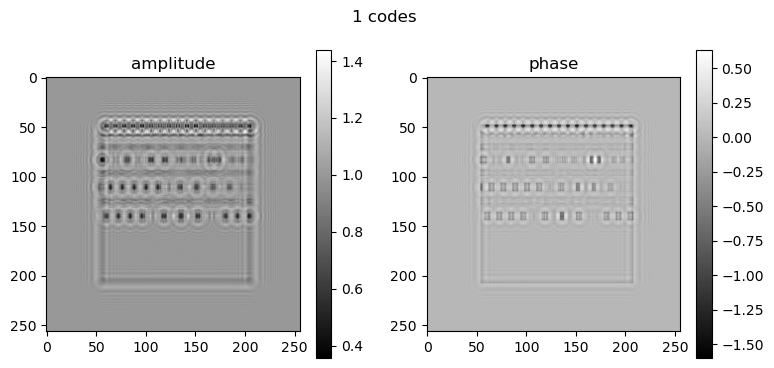

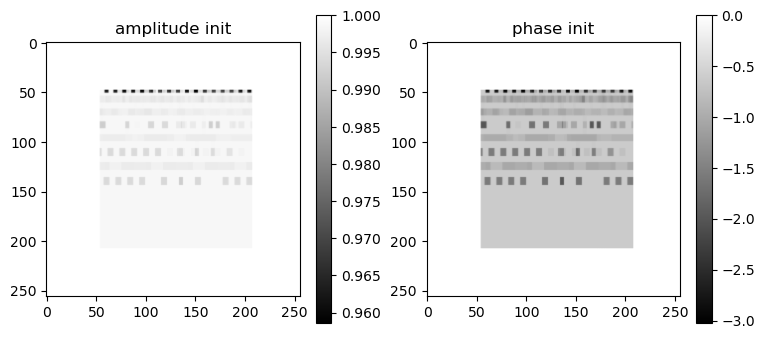

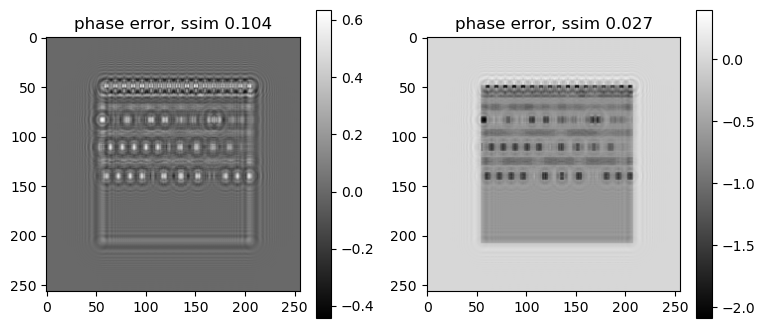

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
fig.suptitle(f'{ncodes} codes')
im=axs[0].imshow(np.abs(rec[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)
psi0 = dxchange.read_tiff(f'/data/modeling/psi_amp_{n}.tiff')[:]*np.exp(1j*dxchange.read_tiff(f'/data/modeling/psi_angle_{n}.tiff')[:])
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi0[0]),cmap='gray')
axs[0].set_title('amplitude init')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi0[0]),cmap='gray')
axs[1].set_title('phase init')
fig.colorbar(im)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi0[0])-np.abs(rec[0]),cmap='gray')
axs[0].set_title('amplitude error')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi0[0])-np.angle(rec[0]),cmap='gray')
axs[1].set_title('phase error')
fig.colorbar(im)
from skimage.metrics import structural_similarity
a = np.abs(rec[0])
b = np.abs(psi0[0])
a-=np.mean(a)
b-=np.mean(b)
data_range=np.amax(b)-np.amin(b)
(score, diff) = structural_similarity(a,b, full=True,data_range=data_range)
axs[0].set_title(f'phase error, ssim {score:.3f}')
a = np.angle(rec[0])
b = np.angle(psi0[0])
a-=np.mean(a)
b-=np.mean(b)
data_range=np.amax(b)-np.amin(b)
(score, diff) = structural_similarity(a,b, full=True,data_range=data_range)
print("Image similarity", score)
axs[1].set_title(f'phase error, ssim {score:.3f}')

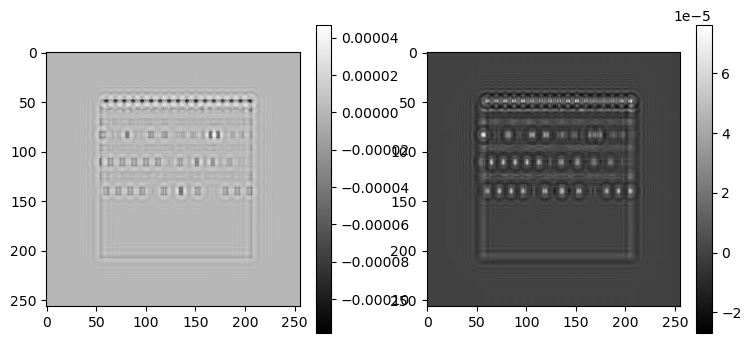

In [10]:
psi = pslv.logtomo(rec)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.real(psi[0]),cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(np.imag(psi[0]),cmap='gray')
fig.colorbar(im)

In [11]:
shifts = np.load('shifts.npy')
psis = psi.copy()
for k in range(ntheta):
    psis[k] = np.roll(psi[k],(-shifts[k,0],-shifts[k,1]),axis=(0,1))

In [12]:
def line_search(minf, gamma, u, fu, d, fd):
    """ Line search for the step sizes gamma"""

    while(minf(u, fu)-minf(u+gamma*d, fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

def cg_tomo(data, init, piter):
    """Conjugate gradients method for tomography"""

    # minimization functional
    def minf(u,fu):
        f = cp.linalg.norm(fu-data)**2            
        return f        
    u = init.copy()
    
    gamma = 1# init gamma as a large value
    for i in range(piter):
        u = cp.ascontiguousarray(u)
        fu = tslv.fwd_tomo(u)            
        
        grad = tslv.adj_tomo(fu-data)/ntheta/n
        
        # Dai-Yuan direction
        if i == 0:
            d = -grad
        else:
            d = -grad+cp.linalg.norm(grad)**2 / \
                (1e-30+(cp.sum(cp.conj(d)*(grad-grad0))))*d
        grad0 = grad
        # line search
        # fd = tslv.fwd_tomo(d)
        gamma = 1 
        # gamma = line_search(minf, gamma, u, fu, d, fd)
        u = u + gamma*d
        # print(f'{i}) {gamma=}, err={minf(u,fu)}')
    
    return u

def cg_tomo_batch(data, init, piter):
    """Batch of Tomogarphy transforms"""
    res = np.zeros([nz, n, n], dtype='complex64')
    for ids in holotomo.utils.chunk(range(nz), pnz):
        # copy data part to gpu
        data_gpu = cp.ascontiguousarray(cp.array(data[:,ids]))
        init_gpu = cp.array(init[ids])
        # Radon transform
        res_gpu = cg_tomo(data_gpu, init_gpu, piter)
        # copy result to cpu
        res[ids] = res_gpu.get()
    return res


titer = 64 # number of CG iters
init = np.zeros([nz,n,n],dtype='complex64')  # initial guess
urec = cg_tomo_batch(psis, init, titer)


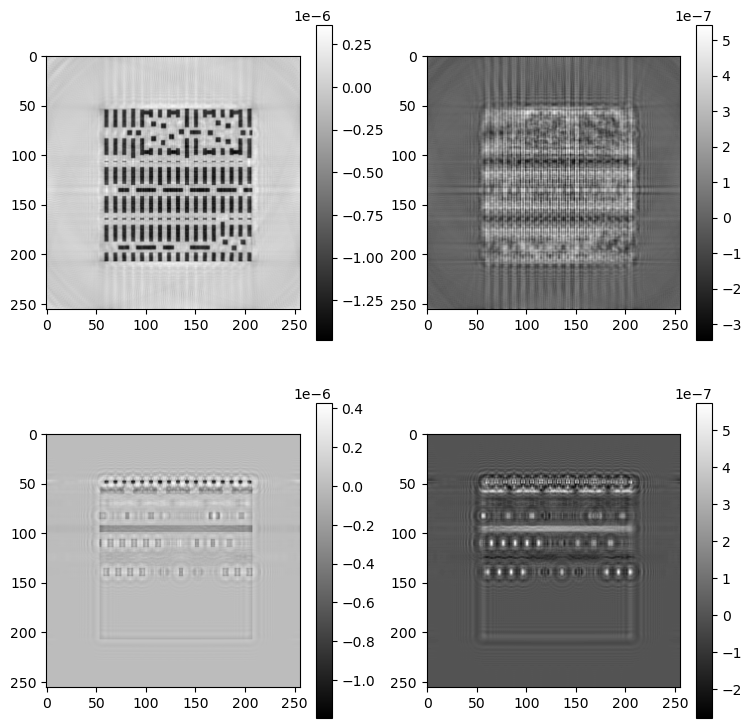

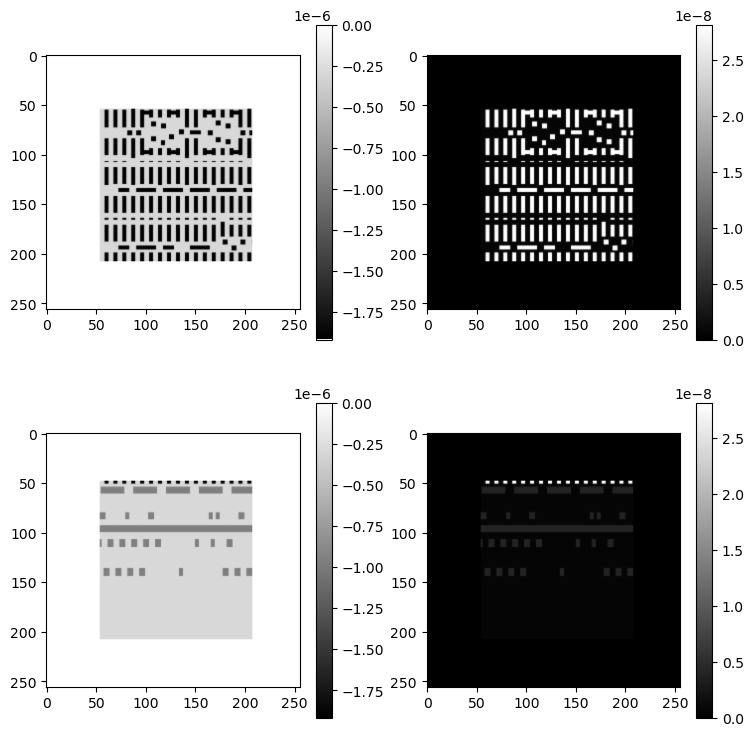

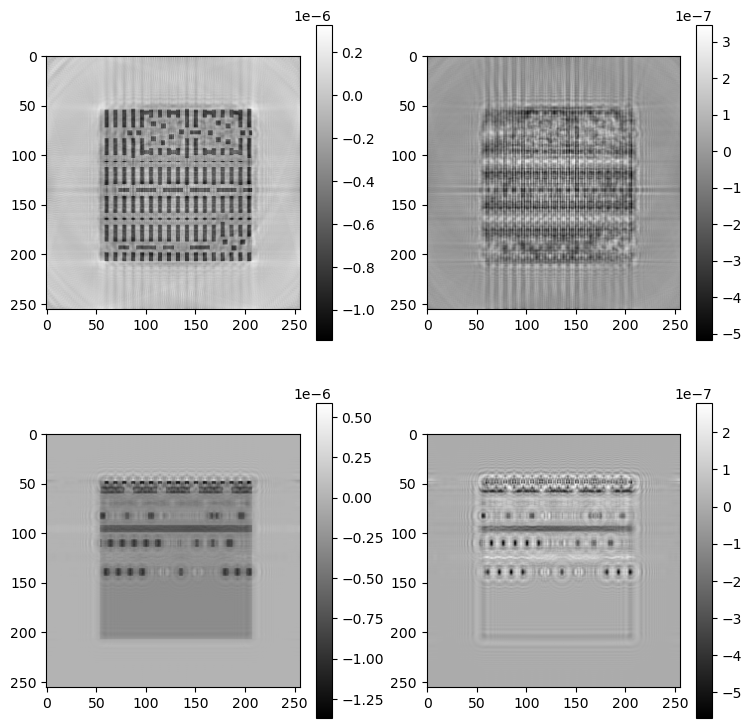

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(urec[48+nz//2-256//2].real,cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(urec[48+nz//2-256//2].imag,cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(urec[:,n//2].real,cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(urec[:,n//2].imag,cmap='gray')
fig.colorbar(im)


beta0 = dxchange.read_tiff('data/beta-chip-192.tiff')
delta0 = dxchange.read_tiff('data/delta-chip-192.tiff')

#pad with zeros
beta = np.zeros([nz,n,n],dtype='float32')
delta = np.zeros([nz,n,n],dtype='float32')
delta[nz//2-96:nz//2+96,n//2-96:n//2+96,n//2-96:n//2+96] = delta0
beta[nz//2-96:nz//2+96,n//2-96:n//2+96,n//2-96:n//2+96] = beta0 

u = delta+1j*beta
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(u[48+nz//2-256//2].real,cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(u[48+nz//2-256//2].imag,cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(u[:,n//2].real,cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(u[:,n//2].imag,cmap='gray')
fig.colorbar(im)

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(u[48+nz//2-256//2].real-urec[48+nz//2-256//2].real,cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(u[48+nz//2-256//2].imag-urec[48+nz//2-256//2].imag,cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(u[:,n//2].real-urec[:,n//2].real,cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(u[:,n//2].imag-urec[:,n//2].imag,cmap='gray')
fig.colorbar(im)


0/513) Lagrangian terms: [ 1.2e+04 3.5e+03 1.7e+03 1.7e+04 ]


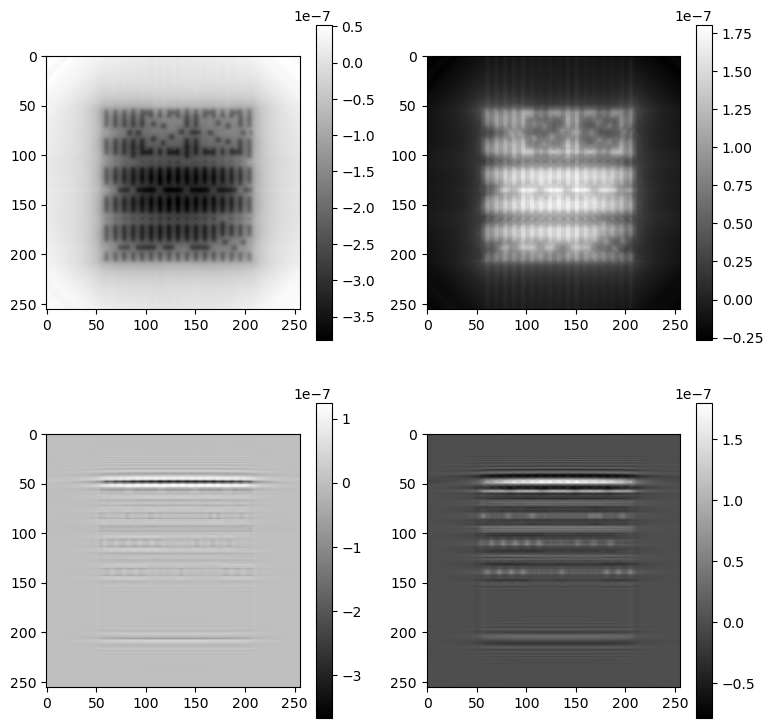

4/513) Lagrangian terms: [ 1.7e+03 1.3e+02 7.4e+02 2.6e+03 ]
8/513) Lagrangian terms: [ 5.1e+02 -6.9e+01 1.7e+02 6.1e+02 ]
12/513) Lagrangian terms: [ 2.3e+02 -1.8e+01 3.7e+01 2.5e+02 ]
16/513) Lagrangian terms: [ 1.6e+02 -4.5e+00 1.3e+01 1.7e+02 ]
20/513) Lagrangian terms: [ 1.3e+02 -2.4e+00 6.4e+00 1.4e+02 ]
24/513) Lagrangian terms: [ 1.2e+02 -1.6e+00 3.9e+00 1.2e+02 ]
28/513) Lagrangian terms: [ 1.1e+02 -1.1e+00 2.8e+00 1.1e+02 ]
32/513) Lagrangian terms: [ 1.0e+02 -1.3e+00 1.6e+00 1.0e+02 ]
36/513) Lagrangian terms: [ 9.7e+01 -9.6e-01 1.3e+00 9.8e+01 ]
40/513) Lagrangian terms: [ 9.3e+01 -7.1e-01 1.1e+00 9.4e+01 ]
44/513) Lagrangian terms: [ 9.0e+01 -5.4e-01 9.9e-01 9.0e+01 ]
48/513) Lagrangian terms: [ 8.7e+01 -4.1e-01 8.8e-01 8.8e+01 ]
52/513) Lagrangian terms: [ 8.5e+01 -3.2e-01 7.8e-01 8.5e+01 ]
56/513) Lagrangian terms: [ 8.3e+01 -2.3e-01 7.0e-01 8.3e+01 ]
60/513) Lagrangian terms: [ 8.1e+01 -1.3e-01 6.4e-01 8.2e+01 ]
64/513) Lagrangian terms: [ 8.0e+01 -3.4e-02 6.0e-01 8.0e+

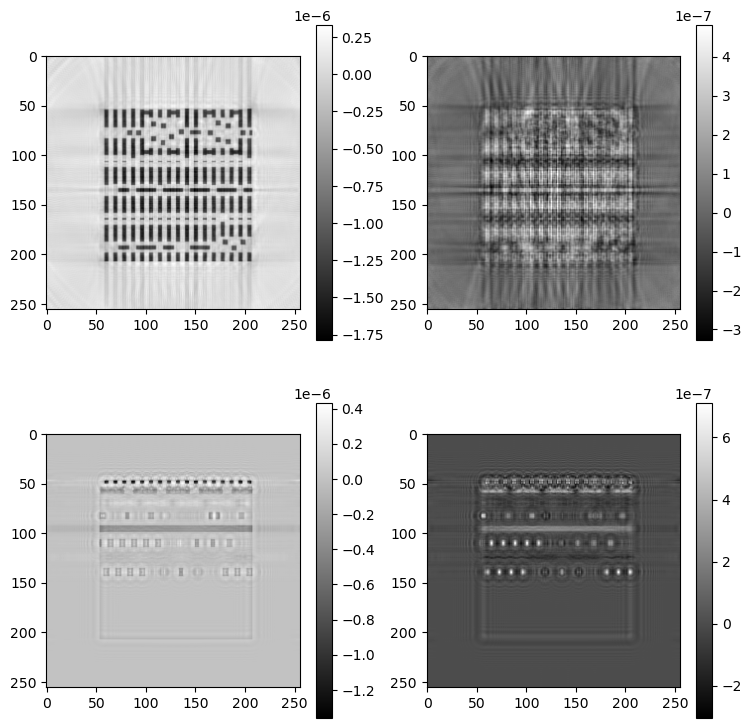

68/513) Lagrangian terms: [ 7.8e+01 6.6e-02 5.6e-01 7.9e+01 ]
72/513) Lagrangian terms: [ 7.8e+01 1.7e-01 5.3e-01 7.8e+01 ]
76/513) Lagrangian terms: [ 7.7e+01 2.8e-01 5.0e-01 7.8e+01 ]
80/513) Lagrangian terms: [ 7.7e+01 4.0e-01 4.9e-01 7.7e+01 ]
84/513) Lagrangian terms: [ 7.6e+01 5.3e-01 4.8e-01 7.7e+01 ]
88/513) Lagrangian terms: [ 7.6e+01 6.7e-01 4.8e-01 7.8e+01 ]
92/513) Lagrangian terms: [ 7.7e+01 8.2e-01 4.8e-01 7.8e+01 ]
96/513) Lagrangian terms: [ 7.7e+01 1.0e+00 5.0e-01 7.9e+01 ]
100/513) Lagrangian terms: [ 7.8e+01 1.2e+00 5.3e-01 8.0e+01 ]
104/513) Lagrangian terms: [ 8.0e+01 1.6e+00 6.1e-01 8.2e+01 ]
108/513) Lagrangian terms: [ 8.1e+01 1.5e+00 5.4e-01 8.3e+01 ]
112/513) Lagrangian terms: [ 8.3e+01 2.0e+00 7.0e-01 8.6e+01 ]
116/513) Lagrangian terms: [ 8.6e+01 2.1e+00 7.3e-01 8.8e+01 ]
120/513) Lagrangian terms: [ 8.8e+01 2.3e+00 8.7e-01 9.1e+01 ]
124/513) Lagrangian terms: [ 9.1e+01 2.6e+00 1.0e+00 9.5e+01 ]
128/513) Lagrangian terms: [ 9.4e+01 3.9e+00 1.5e+00 9.9e+01 ]


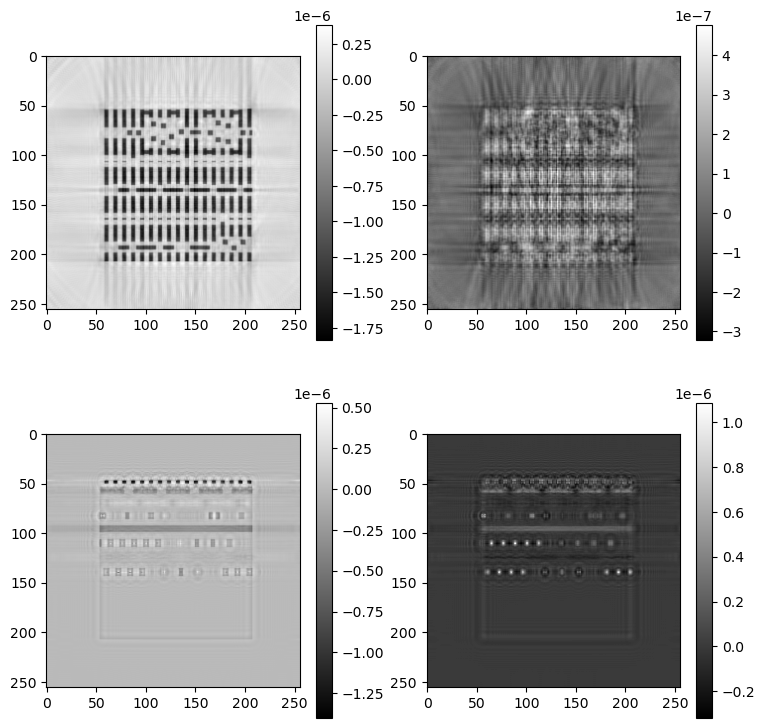

132/513) Lagrangian terms: [ 9.7e+01 3.3e+00 1.4e+00 1.0e+02 ]
136/513) Lagrangian terms: [ 1.0e+02 3.3e+00 1.5e+00 1.1e+02 ]
140/513) Lagrangian terms: [ 1.0e+02 3.4e+00 1.5e+00 1.1e+02 ]
144/513) Lagrangian terms: [ 1.1e+02 3.6e+00 1.6e+00 1.1e+02 ]
148/513) Lagrangian terms: [ 1.1e+02 4.0e+00 1.8e+00 1.2e+02 ]
152/513) Lagrangian terms: [ 1.1e+02 4.7e+00 2.2e+00 1.2e+02 ]
156/513) Lagrangian terms: [ 1.2e+02 5.5e+00 2.7e+00 1.3e+02 ]
160/513) Lagrangian terms: [ 1.2e+02 6.2e+00 3.4e+00 1.3e+02 ]
164/513) Lagrangian terms: [ 1.3e+02 5.4e+00 3.2e+00 1.3e+02 ]
168/513) Lagrangian terms: [ 1.3e+02 5.4e+00 3.5e+00 1.4e+02 ]
172/513) Lagrangian terms: [ 1.3e+02 6.7e+00 4.3e+00 1.4e+02 ]
176/513) Lagrangian terms: [ 1.3e+02 5.2e+00 3.5e+00 1.4e+02 ]
180/513) Lagrangian terms: [ 1.3e+02 5.8e+00 3.8e+00 1.4e+02 ]
184/513) Lagrangian terms: [ 1.4e+02 5.4e+00 3.5e+00 1.5e+02 ]
188/513) Lagrangian terms: [ 1.4e+02 6.5e+00 4.0e+00 1.5e+02 ]
192/513) Lagrangian terms: [ 1.5e+02 8.5e+00 8.1e+00 1.

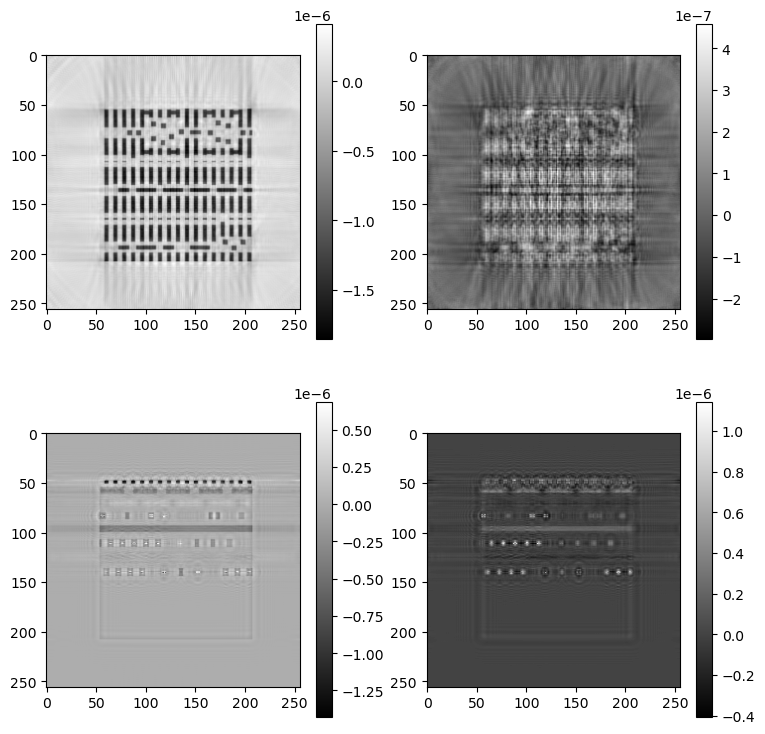

196/513) Lagrangian terms: [ 1.5e+02 9.4e+00 6.5e+00 1.6e+02 ]
200/513) Lagrangian terms: [ 1.5e+02 3.5e+00 3.4e+00 1.5e+02 ]
204/513) Lagrangian terms: [ 1.5e+02 2.4e+00 2.8e+00 1.5e+02 ]
208/513) Lagrangian terms: [ 1.4e+02 1.7e+00 2.2e+00 1.5e+02 ]
212/513) Lagrangian terms: [ 1.4e+02 1.7e+00 2.1e+00 1.5e+02 ]
216/513) Lagrangian terms: [ 1.4e+02 1.5e+00 1.8e+00 1.5e+02 ]
220/513) Lagrangian terms: [ 1.4e+02 1.6e+00 1.6e+00 1.4e+02 ]
224/513) Lagrangian terms: [ 1.4e+02 1.6e+00 1.6e+00 1.4e+02 ]
228/513) Lagrangian terms: [ 1.4e+02 2.0e+00 1.7e+00 1.5e+02 ]
232/513) Lagrangian terms: [ 1.4e+02 3.3e+00 2.7e+00 1.5e+02 ]
236/513) Lagrangian terms: [ 1.4e+02 2.2e+00 2.0e+00 1.5e+02 ]
240/513) Lagrangian terms: [ 1.4e+02 2.5e+00 2.2e+00 1.5e+02 ]
244/513) Lagrangian terms: [ 1.4e+02 1.9e+00 2.6e+00 1.5e+02 ]
248/513) Lagrangian terms: [ 1.4e+02 1.5e+00 2.1e+00 1.5e+02 ]
252/513) Lagrangian terms: [ 1.4e+02 1.2e+00 1.8e+00 1.5e+02 ]
256/513) Lagrangian terms: [ 1.4e+02 1.0e+00 1.7e+00 1.

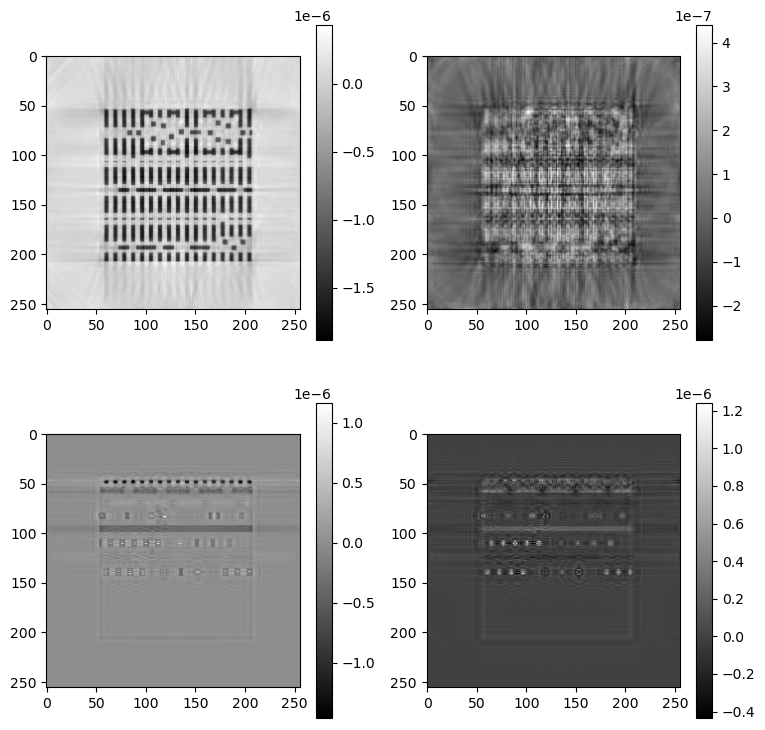

260/513) Lagrangian terms: [ 1.4e+02 1.1e+00 1.6e+00 1.4e+02 ]
264/513) Lagrangian terms: [ 1.4e+02 1.2e+00 1.5e+00 1.4e+02 ]
268/513) Lagrangian terms: [ 1.4e+02 1.5e+00 1.6e+00 1.4e+02 ]
272/513) Lagrangian terms: [ 1.4e+02 2.3e+00 2.3e+00 1.5e+02 ]
276/513) Lagrangian terms: [ 1.4e+02 2.0e+00 2.3e+00 1.5e+02 ]
280/513) Lagrangian terms: [ 1.4e+02 8.7e-01 3.8e+00 1.5e+02 ]
284/513) Lagrangian terms: [ 1.4e+02 2.5e+00 3.3e+00 1.5e+02 ]
288/513) Lagrangian terms: [ 1.4e+02 1.8e+00 2.1e+00 1.5e+02 ]
292/513) Lagrangian terms: [ 1.4e+02 2.0e+00 2.0e+00 1.5e+02 ]
296/513) Lagrangian terms: [ 1.4e+02 1.9e+00 1.8e+00 1.4e+02 ]
300/513) Lagrangian terms: [ 1.4e+02 9.0e-01 1.6e+00 1.4e+02 ]
304/513) Lagrangian terms: [ 1.4e+02 6.4e-01 1.2e+00 1.4e+02 ]
308/513) Lagrangian terms: [ 1.4e+02 4.9e-01 1.1e+00 1.4e+02 ]
312/513) Lagrangian terms: [ 1.4e+02 8.3e-02 1.6e+00 1.4e+02 ]
316/513) Lagrangian terms: [ 1.4e+02 3.2e-01 1.3e+00 1.4e+02 ]
320/513) Lagrangian terms: [ 1.4e+02 3.9e-01 1.0e+00 1.

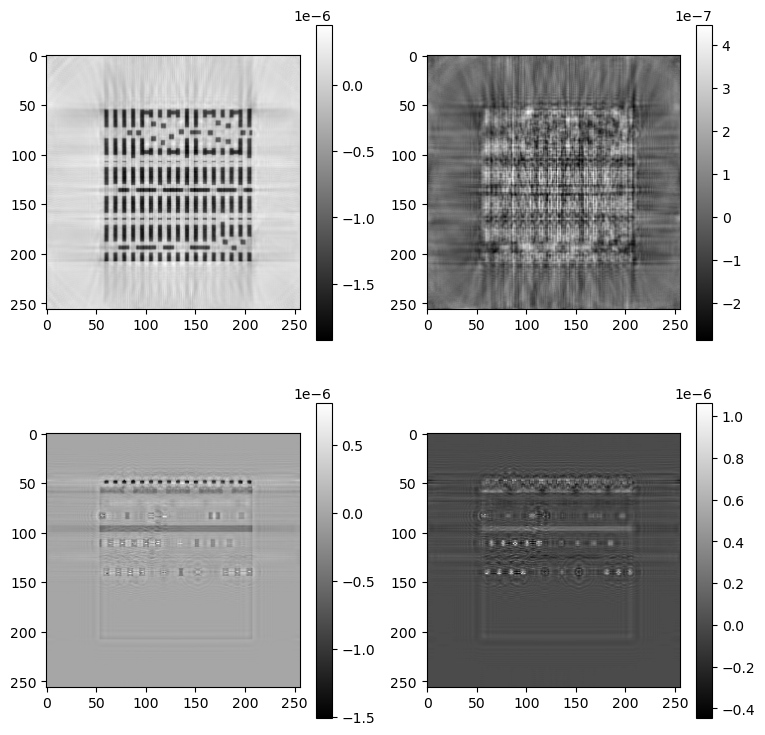

324/513) Lagrangian terms: [ 1.4e+02 8.2e-01 8.1e-01 1.4e+02 ]
328/513) Lagrangian terms: [ 1.4e+02 9.4e-01 1.0e+00 1.4e+02 ]
332/513) Lagrangian terms: [ 1.4e+02 9.0e-01 9.3e-01 1.4e+02 ]
336/513) Lagrangian terms: [ 1.4e+02 1.1e+00 1.1e+00 1.4e+02 ]
340/513) Lagrangian terms: [ 1.4e+02 1.2e+00 1.2e+00 1.4e+02 ]
344/513) Lagrangian terms: [ 1.4e+02 1.1e+00 1.1e+00 1.4e+02 ]
348/513) Lagrangian terms: [ 1.4e+02 9.6e-01 9.5e-01 1.4e+02 ]
352/513) Lagrangian terms: [ 1.4e+02 8.6e-01 9.1e-01 1.4e+02 ]
356/513) Lagrangian terms: [ 1.4e+02 1.2e+00 1.1e+00 1.4e+02 ]
360/513) Lagrangian terms: [ 1.4e+02 1.9e+00 2.2e+00 1.4e+02 ]
364/513) Lagrangian terms: [ 1.4e+02 9.7e-01 4.6e+00 1.5e+02 ]
368/513) Lagrangian terms: [ 1.4e+02 1.3e+00 1.2e+00 1.4e+02 ]
372/513) Lagrangian terms: [ 1.4e+02 8.5e-01 9.9e-01 1.4e+02 ]
376/513) Lagrangian terms: [ 1.4e+02 7.2e-01 7.4e-01 1.4e+02 ]
380/513) Lagrangian terms: [ 1.4e+02 6.3e-01 6.7e-01 1.4e+02 ]
384/513) Lagrangian terms: [ 1.4e+02 6.2e-01 6.0e-01 1.

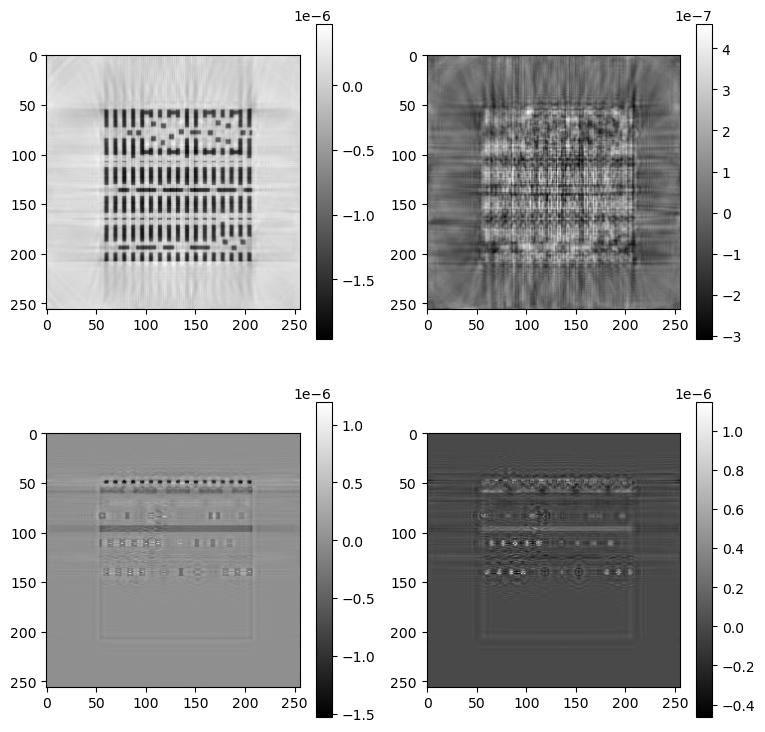

388/513) Lagrangian terms: [ 1.4e+02 6.2e-01 5.9e-01 1.4e+02 ]
392/513) Lagrangian terms: [ 1.4e+02 6.8e-01 5.7e-01 1.4e+02 ]
396/513) Lagrangian terms: [ 1.4e+02 8.5e-01 6.7e-01 1.4e+02 ]
400/513) Lagrangian terms: [ 1.4e+02 9.4e-01 9.8e-01 1.4e+02 ]
404/513) Lagrangian terms: [ 1.4e+02 7.8e-01 7.0e-01 1.4e+02 ]
408/513) Lagrangian terms: [ 1.4e+02 5.6e-01 8.3e-01 1.4e+02 ]
412/513) Lagrangian terms: [ 1.4e+02 6.9e-01 6.8e-01 1.4e+02 ]
416/513) Lagrangian terms: [ 1.4e+02 4.9e-01 9.8e-01 1.4e+02 ]
420/513) Lagrangian terms: [ 1.4e+02 4.5e-01 5.8e-01 1.4e+02 ]
424/513) Lagrangian terms: [ 1.4e+02 3.1e-01 6.1e-01 1.4e+02 ]
428/513) Lagrangian terms: [ 1.4e+02 3.3e-01 4.7e-01 1.4e+02 ]
432/513) Lagrangian terms: [ 1.4e+02 2.6e-01 5.4e-01 1.4e+02 ]
436/513) Lagrangian terms: [ 1.4e+02 3.0e-01 4.8e-01 1.4e+02 ]
440/513) Lagrangian terms: [ 1.4e+02 3.7e-01 3.8e-01 1.4e+02 ]
444/513) Lagrangian terms: [ 1.4e+02 3.8e-01 4.0e-01 1.4e+02 ]
448/513) Lagrangian terms: [ 1.4e+02 4.0e-01 4.5e-01 1.

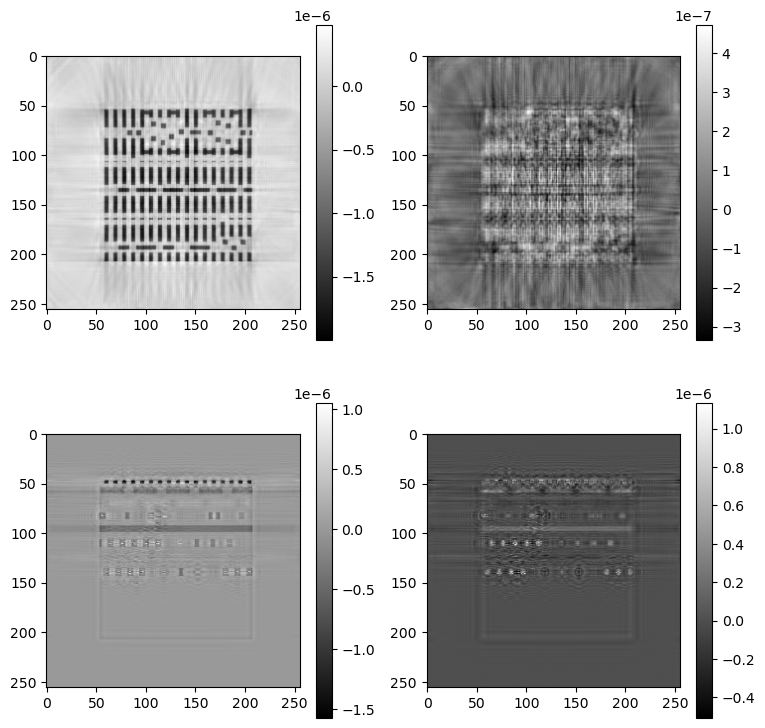

452/513) Lagrangian terms: [ 1.4e+02 5.1e-01 3.9e-01 1.4e+02 ]
456/513) Lagrangian terms: [ 1.4e+02 5.2e-01 4.7e-01 1.4e+02 ]
460/513) Lagrangian terms: [ 1.4e+02 5.8e-01 4.5e-01 1.4e+02 ]
464/513) Lagrangian terms: [ 1.4e+02 4.5e-01 6.2e-01 1.4e+02 ]
468/513) Lagrangian terms: [ 1.4e+02 4.1e-01 4.6e-01 1.4e+02 ]
472/513) Lagrangian terms: [ 1.4e+02 4.1e-01 3.6e-01 1.4e+02 ]
476/513) Lagrangian terms: [ 1.4e+02 3.1e-01 4.3e-01 1.4e+02 ]
480/513) Lagrangian terms: [ 1.4e+02 3.3e-01 4.0e-01 1.4e+02 ]
484/513) Lagrangian terms: [ 1.4e+02 3.4e-01 3.3e-01 1.4e+02 ]
488/513) Lagrangian terms: [ 1.4e+02 3.7e-01 3.1e-01 1.4e+02 ]
492/513) Lagrangian terms: [ 1.4e+02 3.5e-01 3.2e-01 1.5e+02 ]
496/513) Lagrangian terms: [ 1.4e+02 4.1e-01 3.2e-01 1.5e+02 ]
500/513) Lagrangian terms: [ 1.5e+02 4.4e-01 3.4e-01 1.5e+02 ]
504/513) Lagrangian terms: [ 1.5e+02 6.0e-01 4.5e-01 1.5e+02 ]
508/513) Lagrangian terms: [ 1.5e+02 1.1e+00 8.1e-01 1.5e+02 ]
512/513) Lagrangian terms: [ 1.5e+02 5.6e-01 1.2e+00 1.

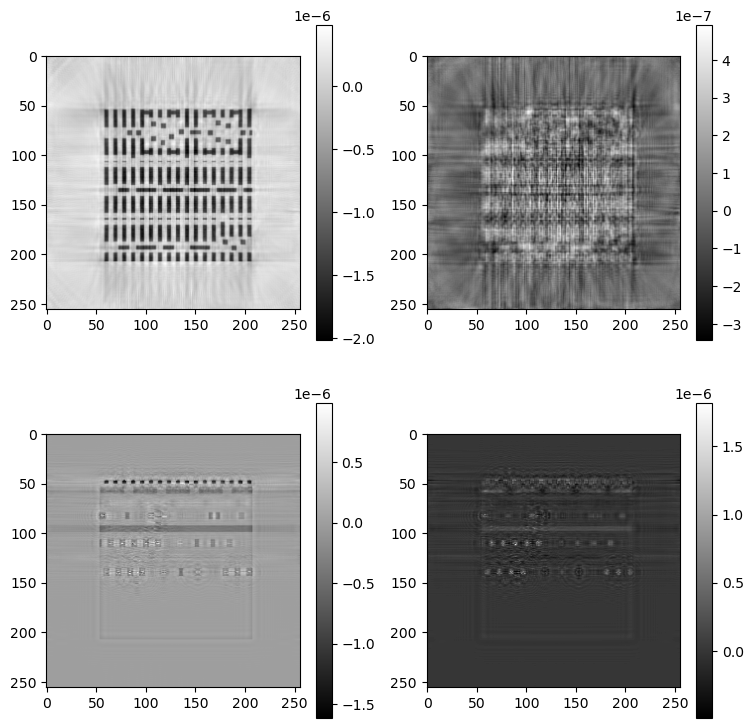

In [14]:
def cg_holo_ext(data, init, prb, h, lamd, rho, piter):
    # minimization functional
    def minf(psi, fpsi):
        f = cp.linalg.norm(cp.abs(fpsi)-cp.sqrt(data))**2
        f += rho*cp.linalg.norm(h-psi+lamd/rho)**2
        return f     
    psi = init.copy()
    maxprb = cp.max(cp.abs(prb))
    for i in range(piter):
        fpsi = pslv.fwd_holo(psi,prb)
        grad = pslv.adj_holo(
           fpsi-cp.sqrt(data)*cp.exp(1j*cp.angle(fpsi)), prb)/maxprb**2
        grad -= rho*(h - psi + lamd/rho)
        
        # Dai-Yuan direction
        # if i == 0:
        d = -grad
        # else:
        #     d = -grad+cp.linalg.norm(grad)**2 / \
        #         ((cp.sum(cp.conj(d)*(grad-grad0))))*d
        grad0 = grad
        # line search
        #fd = pslv.fwd_holo(d, prb)
        gamma = 1#line_search(minf, 1, psi, fpsi, d, fd)
        psi = psi + gamma*d
        #print(f'{i}) {gamma=}, err={minf(psi,fpsi)}')
    
    return psi
def cg_holo_ext_batch(data, init, prb, h, lamd, rho, piter):
    """Batch of CG solvers"""
    
    res = np.zeros([ntheta, nz, n], dtype='complex64')
    
    for ids in holotomo.utils.chunk(range(ntheta), ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        init_gpu = cp.array(init[ids])
        h_gpu = cp.array(h[ids])
        lamd_gpu = cp.array(lamd[ids])
        prb_gpu = cp.array(prb[:,ids])            
        # Radon transform
        res_gpu = cg_holo_ext(data_gpu, init_gpu,prb_gpu,h_gpu, lamd_gpu, rho, piter)
        # copy result to cpu
        res[ids] = res_gpu.get()
    return res

def take_lagr(data,psi,prb,h,lamd,rho):
    lagr = np.zeros(4)
    fpsi = pslv.fwd_holo_batch(psi,prb)    
    lagr[0] = np.linalg.norm(np.abs(fpsi) - np.sqrt(data))**2
    lagr[1] = 2*np.sum(np.real(np.conj(lamd)*(h-psi)))
    lagr[2] = rho*cp.linalg.norm(h-psi)**2
    lagr[3] = np.sum(lagr)
    return lagr
    
                             
# ADMM for ptycho-tomography problem
def admm(data, psi, prb, h, lamd, u, niter):
    rho=0.5
       
    for i in range(niter):            
        psi = cg_holo_ext_batch(data, psi, prb, h, lamd, rho,8)        
        tmp = pslv.logtomo(psi-lamd/rho)
        for k in range(ntheta):
            tmp[k] = np.roll(tmp[k],(-shifts[k,0],-shifts[k,1]),axis=(0,1))
        u = cg_tomo_batch(tmp, u, 4)            
        h = pslv.exptomo(tslv.fwd_tomo_batch(u))
        for k in range(ntheta):
            h[k] = np.roll(h[k],(shifts[k,0],shifts[k,1]),axis=(0,1))
        # lamd updates
        lamd = lamd + rho * (h-psi)
        # Lagrangians difference between two iterations
        lagr = take_lagr(data, psi,prb, h, lamd, rho)
        if i%4==0:
            print(f"{i}/{niter}) Lagrangian terms: [", *(f"{x:.1e}" for x in lagr), "]")
        if i%64==0:
            fig, axs = plt.subplots(2, 2, figsize=(9, 9))
            im=axs[0,0].imshow(u[48+nz//2-256//2].real,cmap='gray')
            fig.colorbar(im)
            im=axs[0,1].imshow(u[48+nz//2-256//2].imag,cmap='gray')
            fig.colorbar(im)
            im=axs[1,0].imshow(u[:,n//2].real,cmap='gray')
            fig.colorbar(im)
            im=axs[1,1].imshow(u[:,n//2].imag,cmap='gray')
            fig.colorbar(im)
            plt.show()
    return u, psi

psi = np.ones([ntheta,nz,n],dtype='complex64')
h = np.ones([ntheta,nz,n],dtype='complex64')
lamd = np.zeros([ntheta,nz,n],dtype='complex64')
u = np.zeros([nz,n,n],dtype='complex64')

u,psi = admm(data,psi,prb,h,lamd,u,513)

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
fig.suptitle(f'{ncodes} codes')
im=axs[0].imshow(np.abs(urec[50],cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(u[48+nz//2-256//2].real,cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(u[48+nz//2-256//2].imag,cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(u[:,n//2].real,cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(u[:,n//2].imag,cmap='gray')
fig.colorbar(im)


SyntaxError: '(' was never closed (1898815945.py, line 3)

In [ ]:
# dxchange.write_tiff(u.real,'/data/modeling/results/u_admm_random_nocode.tiff',overwrite=True)
# dxchange.write_tiff(np.angle(psi),'/data/modeling/results/psi_admm_random_nocode.tiff',overwrite=True)
# dxchange.write_tiff(urec.real,'/data/modeling/results/u_step_random_nocode.tiff',overwrite=True)
# dxchange.write_tiff(np.angle(psis),'/data/modeling/results/psi_step_random_nocode.tiff',overwrite=True)